In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sns.set(color_codes=True)

In [3]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [4]:
raw_html = simple_get(url = r'https://www.blocket.se/goteborg/bilar?cg=1020&w=1&st=s&ca=31&is=1&l=0&md=th&cb=7&cbl1=1')

In [5]:
html = BeautifulSoup(raw_html, 'html.parser')

In [6]:
item_list = html.find_all('a',attrs={'class':'item_link'})

In [7]:
item_link = item_list[0]
item_link['href']



'https://www.blocket.se/stockholm/Citroen_Berlingo_skap__diesel__AC_80881685.htm?ca=11&w=1'

In [8]:
raw_html2 = simple_get(item_link['href'])
html2 = BeautifulSoup(raw_html2, 'html.parser')

In [9]:
header = html2.find('h1')
name = header.text.replace('\n','').replace('\t','')
name


'Citroen Berlingo skåp, diesel, AC -08'

In [10]:
item_details = html2.find('div',attrs = {'id':'item_details'})

In [11]:
items = item_details.find_all('dl',attrs={'class':'col-xs-4'})

In [12]:
item = items[0]

In [13]:
item

<dl class="col-xs-4">
<dt>Modellår</dt>
<dd><strong>2008</strong></dd>
</dl>

In [14]:
key = item.find('dt').text

In [15]:
value = item.find('dd').text

In [16]:
def clean_string(s):
    s_clean = s.replace('\n','').replace('\t','')
    return s_clean

def clean_string2(s):
    s_clean = clean_string(s).replace(' ','')
    return s_clean

def clean_price(s):
    s_clean = clean_string(s)
    s_clean = s_clean.replace('kr','').replace(' ','')
    price = float(s_clean)
    return price

def find_id_from_href(href):
    
    result = re.search(pattern = r'(\d*).htm',string = href)
    id = int(result.groups(1)[0])
    return id
    
def parse_car(href):
    
    raw_html = simple_get(href)
    html = BeautifulSoup(raw_html, 'html.parser')
    
    header = html.find('h1')
    name = clean_string(header.text)
    
    item_details = html.find('div',attrs = {'id':'item_details'})
    items = item_details.find_all('dl',attrs={'class':'col-xs-4'})
    
    data = pd.Series()
    for item in items:
        key = clean_string2(item.find('dt').text)
        value = clean_string2(item.find('dd').text)
        data[key] = value
        
    data['header'] = name
    data.name = find_id_from_href(href = item_link['href'])
    
    price = html.find('div',attrs={'id':'vi_price'})
    data['price'] = clean_price(price.text)
    
    return data
        
    
        

In [17]:
parse_car(href = item_link['href'])

Modellår                                            2008
Växellåda                                        Manuell
Miltal                                       15000-15499
Tillverkningsår                                     2008
Bränsle                                           Diesel
header             Citroen Berlingo skåp, diesel, AC -08
price                                              22500
Name: 80881685, dtype: object

In [18]:
df_cars = pd.DataFrame()

In [19]:
car_paths = OrderedDict()
car_paths['kangoo'] = r'https://www.blocket.se/goteborg/bilar?cg=1020&w=1&st=s&ccco=1&ca=15&is=1&l=0&md=th&cb=30&cbl1=4'
car_paths['berlingo'] = r'https://www.blocket.se/goteborg/bilar?cg=1020&w=1&st=s&ca=31&is=1&l=0&md=th&cb=7&cbl1=1'
car_paths['partner'] = r'https://www.blocket.se/goteborg/bilar?ca=15&st=s&cg=1020&cb=27&cbl1=14'

In [20]:
def get_cars(car_path,max_cars = None):

    next_page_href = car_path
    df_cars = pd.DataFrame()
    counter = 0

    while not next_page_href is None:
        
        raw_html = simple_get(url = next_page_href)
        html = BeautifulSoup(raw_html, 'html.parser')
        item_links = html.find_all('a',attrs={'class':'item_link'})
        
        for item_link in item_links:
            
            if not max_cars is None:
                if counter > max_cars:
                    return df_cars
            
            try:
                s_car = parse_car(href = item_link['href']).copy()
            except AttributeError:
                continue
            else:
                df_cars = df_cars.append(s_car)
                
            counter+=1
            
        next_page = html.find('a',attrs = {'class':'page_nav'},text = '\n                Nästa sida »\n            ')
        if next_page is None:
            next_page_href = None
        else:
            next_page_href = r'https://www.blocket.se/goteborg/bilar' + next_page['href']
            
    return df_cars    

In [21]:
df_cars = pd.DataFrame()

for car_type,car_path in car_paths.items():
    
    df_car_type_cars = get_cars(car_path = car_path)
    df_car_type_cars['car type'] = car_type
    df_cars = df_cars.append(df_car_type_cars)
     

In [22]:
index = df_cars['Tillverkningsår'] == '-'
df_cars.loc[index,'Tillverkningsår'] = df_cars.loc[index,'Modellår']

In [23]:
def decode_miltal(s_miltal):
    
    parts = s_miltal.split('-')
    
    if len(parts) == 1:
        return float(parts[0])
    elif len(parts) == 2:
        return np.mean([float(parts[0]),float(parts[1])])
    else:
        raise ValueError()
    

In [24]:
df_cars['Miltal'] = df_cars['Miltal'].apply(func = decode_miltal)

In [25]:
float_cols = ['Miltal','Modellår','Tillverkningsår']
df_cars[float_cols] = df_cars[float_cols].astype(float)

In [27]:
try:
    old_cars = pd.read_csv('cars.csv',sep = ';',index_col = 0)
except:
    pass
else:
    df_cars = df_cars.combine_first(old_cars)

In [28]:
df_cars.to_csv('cars.csv',sep = ';')

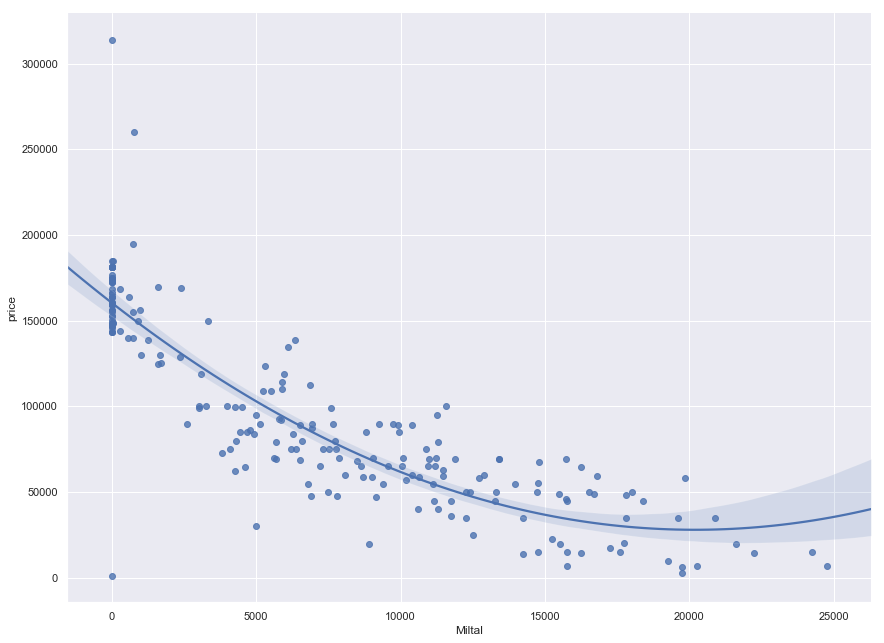

In [33]:
a = sns.lmplot(x="Miltal", y="price", data=df_cars,order=2)
a.fig.set_size_inches(15,10)

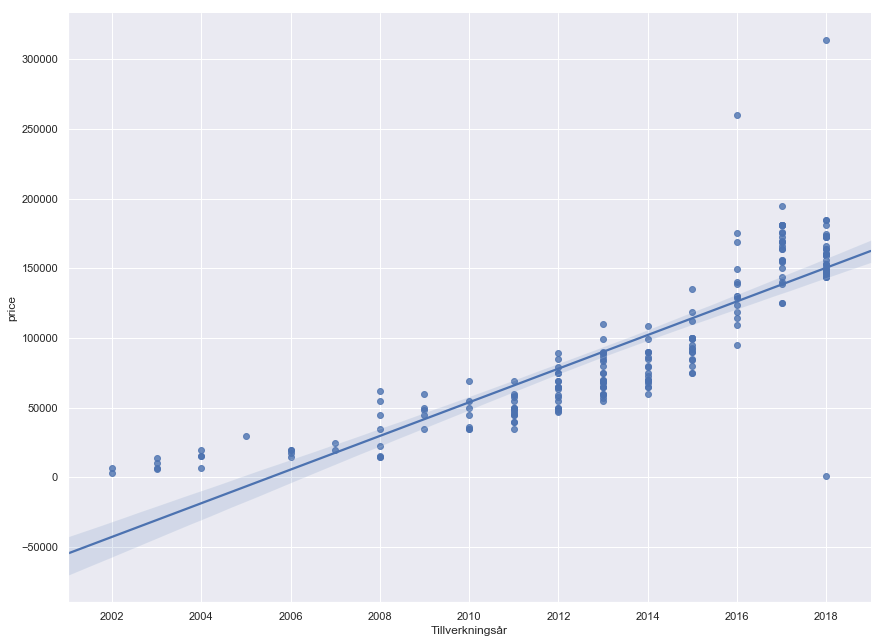

In [34]:
a = sns.lmplot(x="Tillverkningsår", y="price", data=df_cars)
a.fig.set_size_inches(15,10)

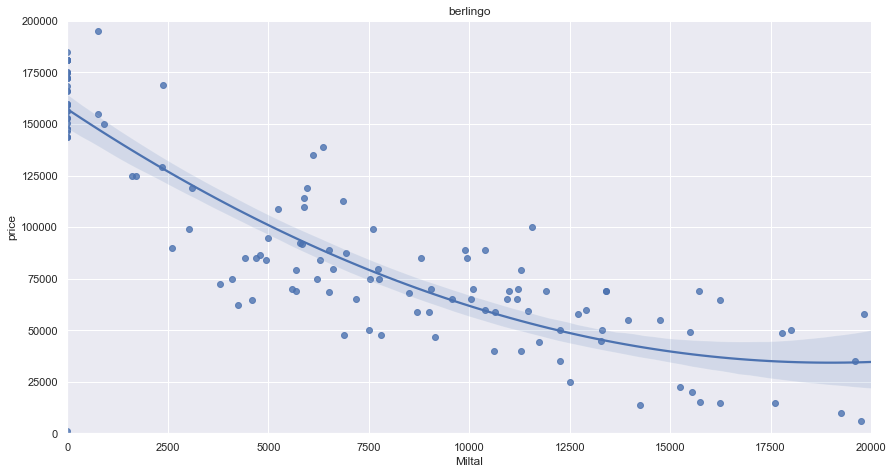

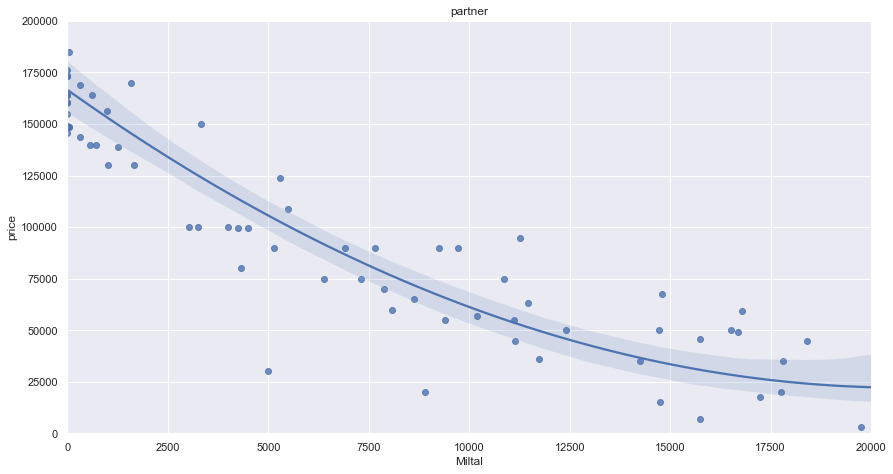

In [54]:
for car_type,group in df_cars.groupby(by = 'car type'):
    
    if len(group) < 10:
        continue
    
    a = sns.lmplot(x="Miltal", y="price", data=group,order = 2)
    fig = a.fig
    fig.set_size_inches(15,7)
    ax = a.ax
    ax.set_title(car_type)
    ax.set_xlim((0,20000))
    ax.set_ylim((0,200000))
    